# Fracture Network Subsampling, Getaberget, Åland Islands

In [1]:
# Python base
from pathlib import Path
from pprint import pprint
from itertools import combinations
import random

# Data analysis
import pandas as pd
import scipy
import scipy.stats as stats
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# fractopo-subsampling imports
import fractopo_subsampling.utils as utils
import fractopo_subsampling.plotting_utils as plotting_utils
from fractopo_subsampling.schema import describe_df_schema

# local config file (./subsampling_config.py)
import subsampling_config

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


# Notebook Parametrization

Collection of some configurations that control the subsampling. Not exhaustive.

In [3]:
# Two methods are presented for constraining the radius of subsample circles:
# 1. The radius can be relatively constrained to a fraction of the full base 
# circle radius (ranging from 10 to 25) from which the subsample is from
radius_constraint = 1.0

# 2. The radius can be directly constrained
min_radius = 5.0
max_radius = 26.0
# stage 1 subsamplings have been collected into a single csv with gather-subsampling invoke cmd
# Path to that csv:
data_path_str = "../results/subsampling/collected/Subsampling_results_15042021.csv"

# stage 2 subsampling can be run or loaded from a csv
# Leave empty if you want to run fresh
stage_2_data_path_str = ""

# How many stage 2 iterations
iterations = 100000

# Save plots to results_path (configured in subsampling_config.py)
save = True

# Read data

In [4]:
# Convert string path to pathlib.Path
data_path = Path(data_path_str)

# Get Paths set in subsampling_config.py
save_path = subsampling_config.results_path
subsampling_path = subsampling_config.subsampling_path

# All configured paths should already exist
assert all(path.exists() for path in (data_path, save_path, subsampling_path))

# Read csv file with pandas into a DataFrame
stage_1_all_subsampled_circles = pd.read_csv(data_path, sep=";", index_col=[0])

# Validate the DataFrame contents with pandera
# Checks and coerces e.g. column types
stage_1_all_subsampled_circles = describe_df_schema.validate(stage_1_all_subsampled_circles)

Reference values from base circle analysis:

In [5]:
# Read csv file with pandas into a DataFrame
reference_values = pd.read_csv(subsampling_config.base_circle_reference_value_csv_path)

# Transform from DataFrame into a Python dict
reference_value_dict = {
    name: value
    for name, value in zip(reference_values["Parameter"], reference_values["Value"])
}

In [6]:
# Put back original parameter names for consistency
reference_value_dict["trace power_law exponent"] = reference_value_dict[
    "Trace Power-law Exponent"
]
reference_value_dict["branch power_law exponent"] = reference_value_dict[
    "Branch Power-law Exponent"
]

In [7]:
reference_value_dict

{'Fracture Intensity P21': 2.0089,
 'Connections per Branch': 1.4435,
 'Trace Power-law Exponent': -1.7546,
 'Branch Power-law Exponent': -2.9051,
 'trace power_law exponent': -1.7546,
 'branch power_law exponent': -2.9051}

# Describe data

In [8]:
print(f"In total, there are {stage_1_all_subsampled_circles.shape[0]} subsampled circles.")

In total, there are 13098 subsampled circles.


In [9]:
# Check how many subsample circles contain no traces (intensity is zero)
sum(stage_1_all_subsampled_circles["Fracture Intensity P21"] == 0)

55

# Data preprocessing

Full dataset contains more simulation data in a spatially extensive area that includes Getaberget. The dataset is filtered to a more concentrated area, Getaberget, spanning roughly 4.5 km of shoreline outcrops and containing only the 13 base circles.

In [10]:
# Keys in the dict are the target area names that we are interested in.
subsampling_config.circle_names_with_diameter

{'Getaberget_20m_4_3_area': 50,
 'Getaberget_20m_9_2_area': 50,
 'Getaberget_20m_8_3_area': 50,
 'Getaberget_20m_7_1_area': 50,
 'Getaberget_20m_7_2_area': 20,
 'Getaberget_20m_5_1_area': 50,
 'Getaberget_20m_2_1_area': 40,
 'Getaberget_20m_2_2_area': 50,
 'Getaberget_20m_1_1_area': 50,
 'Getaberget_20m_1_2_area': 40,
 'Getaberget_20m_1_3_area': 20,
 'Getaberget_20m_1_4_area': 50,
 'Havsvidden_20m_1_area': 50}

In [11]:
# All subsampled target circles
len(stage_1_all_subsampled_circles["name"].unique())

20

Dataset contains named circles that are not spatially close to the others, filter to only a concentrated set of circles (subsampling_config.circle_names_with_diameter).

In [12]:
stage_1_subsampled_base_circles = stage_1_all_subsampled_circles.loc[
    np.isin(stage_1_all_subsampled_circles["name"], list(subsampling_config.circle_names_with_diameter))
]

# Only the remaining base circles
len(stage_1_subsampled_base_circles["name"].unique())

13

Filter out circles with too high areal censoring (15 %). `relative coverage` column contains the relative amount (0.0-1.0).

In [13]:
censoring_threshold = 0.15
print(f"There are {sum(stage_1_subsampled_base_circles['relative coverage'] > censoring_threshold)} circles with higher than {100 * censoring_threshold} % areal censoring.")

There are 160 circles with higher than 15.0 % areal censoring.


In [14]:
# Filter circles with high censoring
stage_1_subsampled_base_circles = stage_1_subsampled_base_circles.loc[stage_1_subsampled_base_circles["relative coverage"] < censoring_threshold]

Filter out circles with less than 30 I- and Y-nodes within the circle according to recommendation of Rohrbaugh et al. 2002.

In [15]:
more_than = stage_1_subsampled_base_circles["Y"] + stage_1_subsampled_base_circles["I"] > 30
print(f"There were {sum(~more_than)} circles with less than 30 IY-nodes.")
stage_1_subsampled_base_circles = stage_1_subsampled_base_circles.loc[more_than]

There were 25 circles with less than 30 IY-nodes.


Filter out circles with less than 110 fracture traces. Fracture trace count ($n_t$) is based on node ($Y$ and $I$) counting:

$N_t = \frac{N_Y + N_I}{2}$

In [16]:
more_than_traces = stage_1_subsampled_base_circles["Number of Traces"] >= 110
print(f"There were {sum(~more_than_traces)} circles with less than 110 traces.")
stage_1_subsampled_base_circles = stage_1_subsampled_base_circles.loc[more_than_traces]

There were 199 circles with less than 110 traces.


In [17]:
# Simulation circle count at this point
stage_1_subsampled_base_circles.shape[0]

8103

Filter to only subsample circles with radius a fraction (`radius_constraint`) of the full base circle. If `radius_constraint == 1.0` no filtering is done.

In [18]:
print(f"Before radius filter {stage_1_subsampled_base_circles.shape[0]}")
stage_1_subsampled_base_circles = stage_1_subsampled_base_circles.loc[
    [
        utils.only_half_radius(
            subsampled_radius,
            subsampling_config.circle_names_with_diameter[name],
            radius_constraint,
        )
        for subsampled_radius, name in zip(stage_1_subsampled_base_circles["radius"], stage_1_subsampled_base_circles["name"])
    ]
]
print(f"After radius filter {stage_1_subsampled_base_circles.shape[0]}")

Before radius filter 8103
After radius filter 8103


Filter to subsample circles with radius within given absolute values (`min_radius`, `max_radius`)

In [19]:
radius_within = np.logical_and(stage_1_subsampled_base_circles["radius"] >= min_radius, stage_1_subsampled_base_circles["radius"] <= max_radius)
print(f"There were {sum(~radius_within)} circles with radius not within given values ({min_radius=}, {max_radius=}).")

There were 0 circles with radius not within given values (min_radius=5.0, max_radius=26.0).


## Is the E-W axis Trace Power-law Trend visible in subsampling?

In [20]:
from shapely.wkt import loads

base_circle_ids = pd.read_csv(subsampling_config.base_circle_ids_csv_path)
id_dict = dict(zip(base_circle_ids["Name"], base_circle_ids["ID"]))

stage_1_subsampled_base_circles["x-coord"] = [loads(point).x for point in stage_1_subsampled_base_circles.geometry.values]
stage_1_subsampled_base_circles["x-coord-avg"] = stage_1_subsampled_base_circles.groupby("name")["x-coord"].transform("mean").astype(int)
stage_1_subsampled_base_circles_sorted_by_x = stage_1_subsampled_base_circles.sort_values(by="x-coord-avg")
stage_1_subsampled_base_circles_sorted_by_x["id"] = [str(id_dict[name]) for name in stage_1_subsampled_base_circles_sorted_by_x["name"].values]

Text(0.5, 6.79999999999999, 'Base Circle ID')

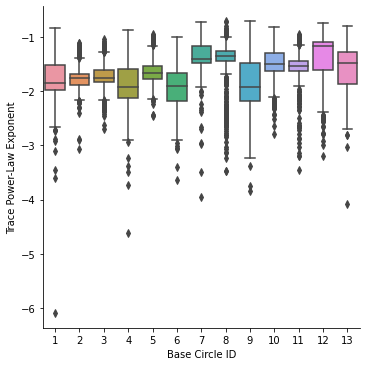

In [21]:
g = sns.catplot(data=stage_1_subsampled_base_circles_sorted_by_x, x="id", y="trace power_law exponent", height=5, kind="box")
g.ax.set_ylabel("Trace Power-Law Exponent")
g.ax.set_xlabel("Base Circle ID")

The dataset is grouped by base circle name resulting in 13 groups.

In [22]:
stage_1_subsampled_base_circles_grouped = stage_1_subsampled_base_circles.groupby("name")
len(stage_1_subsampled_base_circles_grouped)

13

# Analysis of all datasets

The full dataset can be used to fuel the second stage of full subsampling:

* A count of one to all of target area circles are chosen
* From each target area circle one subsampled circle is chosen.

This simulates areal sampling with (multiple) sample circles with varying radius. Only one circle per target area is chosen so spatial variance on the scale of the whole outcrop is always a factor.

Because the base circle radii vary the random subsampling is weighted by the area of the circle so larger circles are picked more often.

It is possible to concentrate the subsampling to e.g. subsampled circles that are within a minimum and maximum area range.

In [23]:
subsample_area_limits = (
    utils.radius_to_area(min_radius),
    utils.radius_to_area(max_radius),
)

We cache the results of the stage 2 subsampling to speed up notebook runs. The filepath for the cache is sensitive to any changes in the underlying `stage_1_subsampled_base_circles` dataset and reruns will occur if e.g. the size, loaded `stage_1_subsampled_base_circles` filepath or constraints change (Change detection by no means absolute, user responsibility to perform rerun if needed.).

In [24]:
stage_2_data_path = Path(stage_2_data_path_str)
if (
    len(stage_2_data_path_str) != 0 
    and stage_2_data_path.exists()
    and stage_2_data_path.is_file()
):
    
    # Load cached stage 2 subsampling csv data
    savepath = stage_2_data_path
else:
    
    # Create new stage 2 subsampling csv data and cache it
    # Note! The cached stage 2 subsamplings are still
    # loaded if the savepath below matches a csv in results_path directory
    # At high iteration counts reruns are pointless as results do not deviate,
    # atleast not enough to affect visual plots
    df_hash = stage_1_subsampled_base_circles.shape[0]
    radius_constraint_hash = int(radius_constraint * 100)
    data_path_hash = data_path.stem
    subsample_area_limits_hash = int(sum(subsample_area_limits))
    
    # Uses some DataFrame attributes to create a "unique" savepath for csv
    # If csv at savepath already exists, load it and use that
    savepath = (
        subsampling_config.results_path
        / f"subsampling/cached_subsamples/agg_df_{df_hash}_{radius_constraint_hash}_{iterations}_{data_path_hash}_{subsample_area_limits_hash}.csv"
    )

# If the subsampling has already been conducted for current dataset it will be loaded from cache
agg_df = utils.cached_subsampling(
    dataframe_grouped=stage_1_subsampled_base_circles_grouped,
    iterations=iterations,
    savepath=savepath,
    subsample_area_limits=subsample_area_limits,
    circle_names_with_diameter=subsampling_config.circle_names_with_diameter,
)

In [25]:
agg_df.describe()

,area,circle_count,Fracture Intensity P21,Connections per Branch,trace power_law exponent,branch power_law exponent,Number of Traces,Number of Branches,radius,I,Y,X,Trace Boundary 1 Intersect Count,Trace Boundary 2 Intersect Count,Trace Boundary 0 Intersect Count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,19212.000000,100000.000000
mean,5276.210352,7.008490,2.001076,1.441719,-1.742385,-2.732433,10365.071025,23532.182475,101.063213,12417.812380,8312.329670,2427.390890,786.994370,6.186914,9970.329980
std,3007.144520,3.741719,0.324846,0.037234,0.215008,0.373954,6246.924950,14324.246447,54.288709,7455.922344,5059.117723,1520.713279,426.629617,4.957074,6041.889543
min,78.570237,1.000000,0.847959,0.882521,-6.091856,-8.219047,110.000000,174.500000,5.000968,125.000000,42.000000,6.000000,17.000000,1.000000,92.000000
25%,2755.794211,4.000000,1.800905,1.425347,-1.868084,-2.880510,5127.500000,11452.500000,54.362756,6177.750000,4032.000000,1137.000000,422.000000,2.000000,4904.000000
50%,5223.576664,7.000000,1.967930,1.441519,-1.746666,-2.697734,10152.750000,23033.250000,101.689433,12154.000000,8142.000000,2357.000000,794.000000,5.000000,9747.500000
75%,7595.279225,10.000000,2.139410,1.458020,-1.623944,-2.541916,15031.000000,34162.125000,147.050502,17976.250000,12093.250000,3536.000000,1144.000000,9.000000,14468.000000
max,15735.156919,13.000000,4.542132,1.700051,-0.710340,-1.104900,31640.500000,72728.500000,241.139137,37731.000000,25550.000000,7769.000000,1908.000000,33.000000,30706.000000


# Variance when whole sample areas are categorized

The areas and sample counts in each simulation can be used to categorize the simulations to visualize the difference between area amount and sample count and their relation to each other. 

## Effect of boundary censoring (not used!)

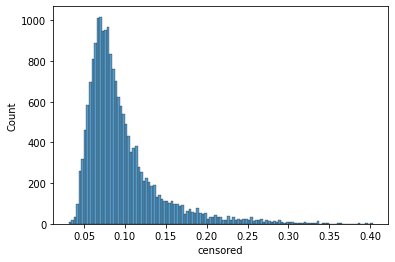

In [26]:
agg_df["censored"] = (
    agg_df["Trace Boundary 1 Intersect Count"]
    + agg_df["Trace Boundary 2 Intersect Count"]
) / agg_df["Number of Traces"]
sns.histplot(data=agg_df, x="censored")
censored_bins = [0, 0.1, 0.2, 1.1]
censored_labels = ["0-10%", "10-20%", "20%+"]
agg_df["censored_binned"] = pd.cut(
    agg_df["censored"], censored_bins, labels=censored_labels
)

## Effect of endpoints (not used!)

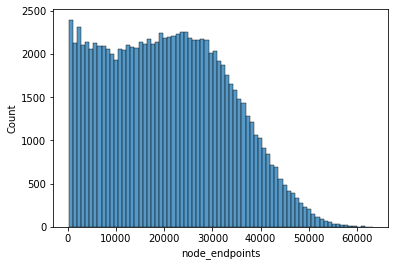

In [27]:
agg_df["node_endpoints"] = agg_df["Y"] + agg_df["I"]
sns.histplot(data=agg_df, x="node_endpoints")
yi_bins = [0, 15000, 30000, 10e10]
yi_labels = ["0-15k", "15k-30k", "30k+"]
agg_df["node_endpoint_binned"] = pd.cut(
    agg_df["node_endpoints"], yi_bins, labels=yi_labels
)

## Effect of total area and circle count (used!)

In [28]:
# Bin iterations based on total sample area in each iteration
# Bin edges
area_bins = [0, 4000, 8000, 20000]

# Labels
area_labels = ["0-4", "4-8", "8-20.8"]

# Column name
area_bin_col = "Total Area $10^3 m^2$"

# Perform binning with pandas cut
agg_df[area_bin_col] = pd.cut(agg_df["area"], area_bins, labels=area_labels)

# Bin iterations based on total circle count in each iteration
cc_bins = [0, 5, 8, 11, 14]
cc_labels = ["1 to 4", "5 to 7", "8 to 10", "11 to 13"]
cc_labels = [label + " circles" for label in cc_labels]
circle_count_col = "Circle Count"
agg_df[circle_count_col] = pd.cut(
    agg_df["circle_count"], cc_bins, labels=cc_labels
)

Create the table of group iteration counts

In [29]:
table_df = agg_df.copy()
new_area_col = area_bin_col.replace("10^3 ", "")
table_df[new_area_col] = table_df[area_bin_col].cat.rename_categories(
    {
        "0-4":"0-4000", 
        "4-8":"4000-8000", 
        "8-20.8":"8000-20800", 
    }
)
level_grouped = table_df.groupby([new_area_col, circle_count_col])

In [30]:
print(level_grouped.area.count().unstack(level=-1).to_markdown(tablefmt="grid"))

+--------------------+------------------+------------------+-------------------+--------------------+
| Total Area $m^2$   |   1 to 4 circles |   5 to 7 circles |   8 to 10 circles |   11 to 13 circles |
+====================+==================+==================+===================+====================+
| 0-4000             |            32977 |             4319 |               247 |                 14 |
+--------------------+------------------+------------------+-------------------+--------------------+
| 4000-8000          |             5351 |            17789 |             13598 |               4708 |
+--------------------+------------------+------------------+-------------------+--------------------+
| 8000-20800         |                5 |             1176 |              9026 |              10790 |
+--------------------+------------------+------------------+-------------------+--------------------+


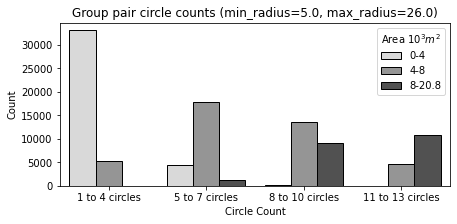

In [31]:
fig = plotting_utils.plot_group_pair_counts(
    agg_df=agg_df,
    x=circle_count_col,
    hue=area_bin_col,
    ylabel="Count",
    xlabel="Circle Count",
    title=f"Group pair circle counts ({min_radius=}, {max_radius=})",
    legend_title=r"Area $10^3m^2$",
)
if save:
    savepath = Path(f"{subsampling_path}/boxplots/circle_amounts_{subsample_area_limits_hash}.svg")
    savepath.mkdir(parents=True, exist_ok=True)
    fig.savefig(
        savepath,
        bbox_inches="tight",
    )

Filter group pairs with very low iteration count (less than 100 samples AND less than 1% of total samples in group pair) as they offer "bad" boxplots with inadequate sample count.

In [32]:
# Save original length for comparison later
full_length = agg_df.shape[0]

# Collect small group pairs into small_groups
small_groups = []

# Iterate over circle count labels
for cc in cc_labels:
    
    # Iterate over area labels
    for aa in area_labels:
        
        # Find rows representing the group pair
        query = np.logical_and(
            agg_df[circle_count_col] == cc, agg_df[area_bin_col] == aa
        )
        
        # Add to small_groups if not within the thresholds
        if sum(query) / full_length < 0.01 and sum(query) < 100:
            small_groups.append((cc, aa))

# Initialize boolean list with all True
filterer = [True] * full_length

# Iterate over the group pairs in small_groups
for cc, aa in small_groups:
    
    # Filterer for rows that are in small_groups
    group_filterer = [
        not (circle_cc == cc and area_aa == aa)
        for circle_cc, area_aa in zip(
            agg_df[circle_count_col], agg_df[area_bin_col]
        )
    ]
    
    # Accumulate the filtering
    filterer = np.logical_and(filterer, group_filterer)

# Filter out the iterations
filtered_agg = agg_df.loc[filterer]

print(f"Filtered {full_length - filtered_agg.shape[0]} iterations.")

Filtered 19 iterations.


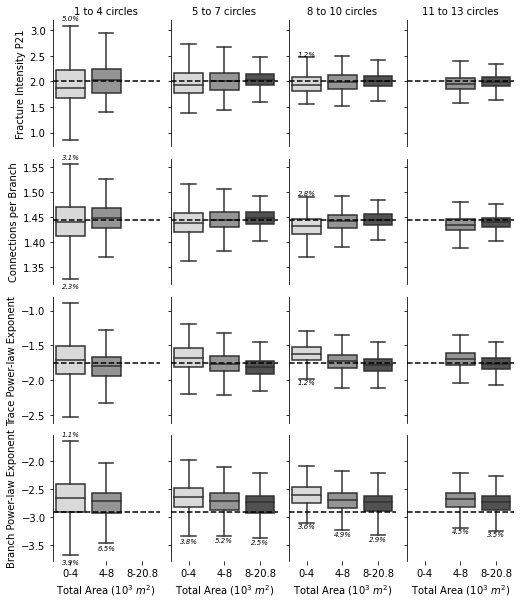

In [33]:
# Plot pair grouped boxplots
fig = plotting_utils.grouped_boxplots(
    aggregate_df=filtered_agg,
    reference_value_dict=reference_value_dict,
    group_col_first=circle_count_col,
    group_col_second=area_bin_col,
    group_first_labels=cc_labels,
    group_second_labels=area_labels,
    multip_diff=1.125,
)

# Save boxplot fig
savepath = Path(f"{subsampling_path}/boxplots/grouped_boxplots.svg")
if save:
    savepath.mkdir(parents=True, exist_ok=True)
    fig.savefig(savepath, bbox_inches="tight")

## Discussion

We fit beta distributions to two group pairs for two parameters. All relevant statistics are within the plots.

In [34]:
# Choose two group pairs
circle_groups = ("5 to 7 circles", "8 to 10 circles")
area_groups = ("4-8", "4-8")

# Only interested in P21 and Trace Power-Law Exponent for now
params = ("Fracture Intensity P21", "trace power_law exponent")

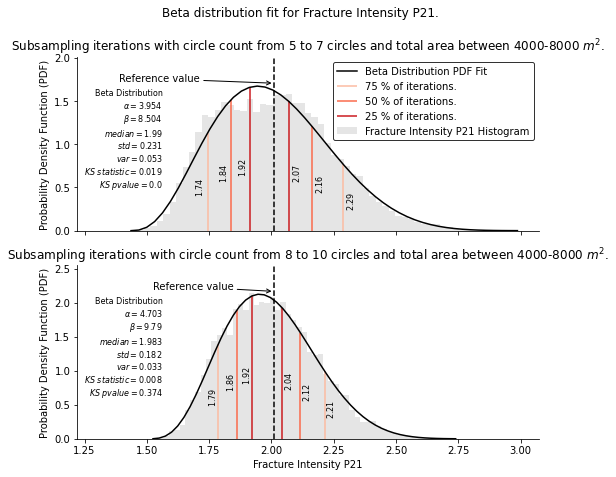

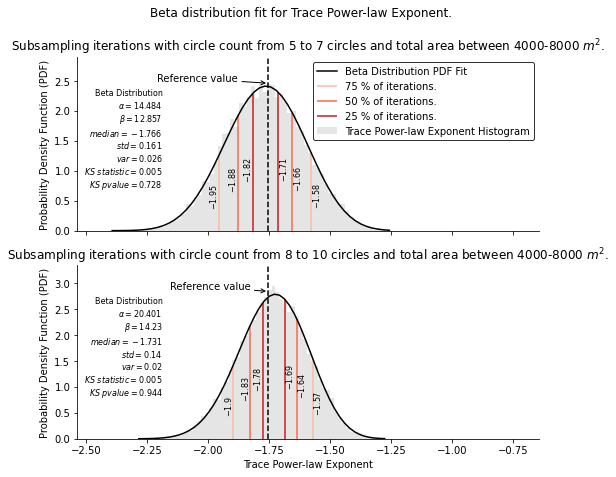

In [35]:
# Iterate over the given params
for param in params:
    
    # Initialize plot
    fig, axes = plt.subplots(2, 1, figsize=utils.paper_figsize(0.6), sharex=True)
    
    # Iterate over circle and area groups and associated axes
    for circle_group, area_group, ax in zip(circle_groups, area_groups, axes):
        
        # Plot the distribution for group-pair
        plotting_utils.plot_distribution(
            dist=stats.beta,
            dist_str="beta",
            agg_df=agg_df,
            circle_group=circle_group,
            area_group=area_group,
            param=param,
            reference_value_dict=reference_value_dict,
            ax=ax,
            legend=ax == axes[0],
            area_bin_col=area_bin_col,
            circle_count_col=circle_count_col,
        )
    
    # Give title
    fig.suptitle(f"Beta distribution fit for {utils.param_renamer(param)}.")
    
    # Save figure
    plot_name = "".join([part[0] for part in param.split(" ")])
    savepath = Path(f"{subsampling_path}/beta_{plot_name}.svg")
    if save:
        savepath.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, bbox_inches="tight")